## Import libraries

In [ ]:
import os
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

## Configs

In [2]:
class Config:
    TRAIN_DIR = 'SD1/train10'  
    VAL_DIR = 'SD1/val'
    INPUT_SIZE = (512, 512)
    NUM_EPOCHS = 150
    BATCH_SIZE = 8
    BETAS=(0.9,0.999)
    DECAY=0.001
    LR =1e-5
    PATIENCE=10

## Preprocessing Dataset

A custom dataset class was implemented to train the model to remove glare or highlights from images.

<strong>Image Directory</strong>: The image directory is passed as an argument containing all the image files. The paths of all the image files are collated.

<strong>Image Slicing</strong>: As the given image is concatenated in this manner: [Ground Truth Image, Input, Glare Mask], each image is split horizontally into three equal-width parts to get the Ground Truth Image and Input images respectively

<strong>Image Transformation</strong>: For each split image, it is resized to 512x512 and converted to grayscale. Since the input used for training is [0, 1], the image is converted to a tensor without normalization.

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, input_size=(512, 512)):
        super(CustomImageDataset, self).__init__()
        self.image_dir = image_dir
        self.input_size = input_size
        self.file_list = []
        for f in os.listdir(self.image_dir):
            if f.endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img_path = os.path.join(self.image_dir, f)
                    self.file_list.append(img_path)
                except Exception as e:
                    print(f"Skipping invalid image {f}: {e}")
        self.transform = transforms.Compose([
            transforms.Resize(self.input_size),  # (H, W)
            transforms.ToTensor(),              # Converts to [0, 1] tensor
        ])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        #img = Image.open(img_path).convert("RGB")
        img = Image.open(img_path).convert("L")
        
        w, h = img.size
        slice_w = w // 3  #512

        gt_img   = img.crop((0, 0, slice_w, h))              # Left third
        input_img = img.crop((slice_w, 0, 2 * slice_w, h))    # Middle third
        mask_img  = img.crop((2 * slice_w, 0, w, h))    # Right third

        gt_tensor = self.transform(gt_img)
        input_tensor = self.transform(input_img)
        mask_tensor = self.transform(mask_img)

        return {
            'gt': gt_tensor,
            'input': input_tensor,
            'mask': mask_tensor
        }

In [4]:
config = Config()

In [5]:
train_dataset = CustomImageDataset(config.TRAIN_DIR, config.INPUT_SIZE)
val_dataset = CustomImageDataset(config.VAL_DIR, config.INPUT_SIZE)

### Check the image slicing is correct

In [6]:
sample = train_dataset[0]
print(sample['gt'].shape, sample['input'].shape, sample['mask'].shape)

torch.Size([1, 512, 512]) torch.Size([1, 512, 512]) torch.Size([1, 512, 512])


In [7]:
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=4)

### Check the dataloading is correct

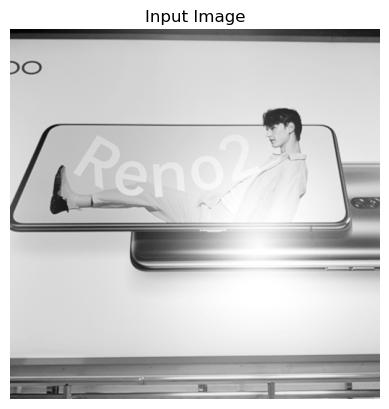

In [8]:
batch = next(iter(train_loader))
input_image= batch['input'][0]

input_image = batch['input'][0].squeeze(0).numpy()  # Remove channel dim
plt.imshow(input_image, cmap='gray')
plt.title("Input Image")
plt.axis('off')
plt.show()

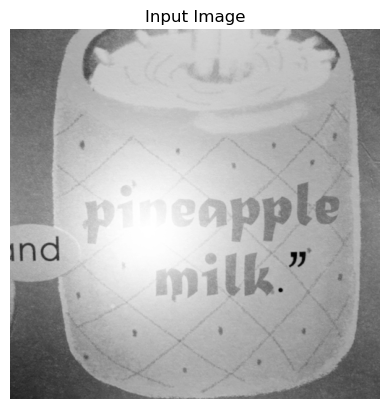

In [9]:
batch = next(iter(val_loader))
input_image= batch['input'][0]

input_image = batch['input'][0].squeeze(0).numpy()  # Remove channel dim
plt.imshow(input_image, cmap='gray')
plt.title("Input Image")
plt.axis('off')
plt.show()

## Model

The model used is a convolutional autoencoder, with skip connections added, resembling an Unet model. Skip connections to preserve spatial details lost during downsampling. Withoout skip connections, the the generated image will be blurry.

<strong>Model Architecture</strong>:
The input is downsampled 5 times, with the 5th layer being the bottleneck. Then, the decoder unsamples 5 times as well to reconstruct the image, concatenating the skip connections sequentially from the 4th encoder layer, up till the first encoder layer.

The model takes in the glare-affected grayscale image (input) and generates a grayscale image with no glare. The output is compared with ground truth image with no glare (target).

<strong>Assumptions</strong>: Input image will be grayscale and of size 512x512. Input to model must also be a tensor.

In [10]:
class UNetAutoencoder(nn.Module):
    def __init__(self):
        super(UNetAutoencoder, self).__init__()

        self.enc1 = self.conv_block(1, 64)     
        self.enc2 = self.conv_block(64, 128)   
        self.enc3 = self.conv_block(128, 256)  
        self.enc4 = self.conv_block(256, 512)  
        self.enc5 = self.conv_block(512, 1024) #bottlenect

        self.up1 = self.up_block(1024, 512)    # 32 -> 64
        self.up2 = self.up_block(1024, 256)    # 64 -> 128 (concat with enc4)
        self.up3 = self.up_block(512, 128)     # 128 -> 256 (concat with enc3)
        self.up4 = self.up_block(256, 64)      # 256 -> 512 (concat with enc2)
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
        self.pool = nn.MaxPool2d(2)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        e5 = self.enc5(self.pool(e4))

        d1 = self.up1(e5)
        d1 = torch.cat([d1, e4], dim=1)
        d2 = self.up2(d1)
        d2 = torch.cat([d2, e3], dim=1)
        d3 = self.up3(d2)
        d3 = torch.cat([d3, e2], dim=1)
        d4 = self.up4(d3)
        d4 = torch.cat([d4, e1], dim=1)

        out = self.final(d4)
        return out

## Training

<strong>Loss Function</strong>: L1 Loss (Mean Absolute Error)

<strong>Optimizer</strong>: Adam

<strong>Early Stopping</strong>: Early stopping is implemented to prevent overfitting. EarlyStopper monitors validation loss and saves the model with the lowest validation loss after every epoch. If the validation loss doesn’t improve after a defined number of iterations (patience), training stops.

<strong>For each epoch</strong>:
The model is trained on train_loader and subsequently evaluated on val_loader. The losses from training and validation are stored for plotting later.

In [11]:
def train_model(model, train_loader, criterion):
    epoch_loss = 0
    train_steps = len(train_loader)

    for step, batch in enumerate(train_loader):
        y_sample = batch['gt'].to("cuda")
        x_sample = batch['input'].to("cuda")

        predictions = model(x_sample)

        loss = criterion(predictions, y_sample)
        
        model_optimizer.zero_grad()
        loss.backward()
        model_optimizer.step()
        epoch_loss += loss.item()

        del x_sample, y_sample, predictions, loss
        
    return epoch_loss / train_steps

def validate_model(model, val_loader, criterion):
    model.eval()
    epoch_loss = 0
    train_steps = len(val_loader)
    
    with torch.no_grad():
        for step, batch in enumerate(val_loader):
            y_sample = batch['gt'].to("cuda")
            x_sample = batch['input'].to("cuda")
    
            predictions = model(x_sample)
            loss = criterion(predictions, y_sample)
            epoch_loss += loss.item()
    
            del x_sample, y_sample, predictions, loss
    
    return epoch_loss / train_steps

In [12]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0, model=None, model_path=None):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_loss = float('inf')
        self.model=model
        self.model_path= model_path

    def early_stop(self, loss):
        if loss < self.min_loss:
            self.min_loss = loss
            self.counter = 0
            torch.save(self.model.state_dict(), self.model_path)
            print(f'Saving best model with {self.min_loss:.4f} loss')
        elif loss <= (self.min_loss - self.min_delta):
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                return True
        return False


def train_process(model, train_loader, val_loader, criterion, optimizer, patience, model_path, num_epochs):
    print("current model_path: ", model_path)
    train_loss, val_loss=[], []
    early_stopping = EarlyStopper(patience=patience, min_delta=0, model=model, model_path=model_path)
    for epoch in range(num_epochs):
        epoch_loss = train_model(model, val_loader, criterion)
        train_loss.append(epoch_loss)
        
        epoch_val_loss= validate_model(model, val_loader, criterion)
        val_loss.append(epoch_val_loss)

        print(f"Epoch {epoch + 1}")
        print(f"L1 Training Loss: {epoch_loss:.4f}")
        print(f"L1 Val Loss: {epoch_val_loss:.4f}")

        if early_stopping.early_stop(epoch_val_loss):
            print("Early stopping")
            break

    # # Load the best model
    model.load_state_dict(torch.load(model_path))
    return model, train_loss, val_loss

### Plot function for the training and validation losses. The plot of early stopping if any is also highlighted.

In [13]:
def plot_loss(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)  
    min_val_loss=min(val_loss)
    min_val_loss_index=val_loss.index(min_val_loss)
    plt.figure(figsize=(8, 6))  
    plt.plot(epochs, train_loss, marker='o', label='Train_Loss')
    plt.plot(epochs, val_loss, marker='x', label='Validation_Loss')
    plt.axvline(x = min_val_loss_index+1, color = 'r', label = 'max_val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

In [14]:
model_path="best_model_unet.pth"
criterion=nn.L1Loss()
model=UNetAutoencoder().to("cuda")

model_optimizer=torch.optim.Adam(model.parameters(),lr=config.LR,betas=config.BETAS,weight_decay=config.DECAY)

### Training and validation results

In [15]:
trained_model, train_loss, val_loss= train_process(model, train_loader, val_loader, criterion, model_optimizer, config.PATIENCE, model_path, config.NUM_EPOCHS)

current model_path:  best_model_unet.pth
Epoch 1
L1 Training Loss: 0.1387
L1 Val Loss: 0.1140
Saving best model with 0.1140 loss
Epoch 2
L1 Training Loss: 0.1023
L1 Val Loss: 0.0959
Saving best model with 0.0959 loss
Epoch 3
L1 Training Loss: 0.0921
L1 Val Loss: 0.0871
Saving best model with 0.0871 loss
Epoch 4
L1 Training Loss: 0.0848
L1 Val Loss: 0.0792
Saving best model with 0.0792 loss
Epoch 5
L1 Training Loss: 0.0788
L1 Val Loss: 0.0741
Saving best model with 0.0741 loss
Epoch 6
L1 Training Loss: 0.0746
L1 Val Loss: 0.0705
Saving best model with 0.0705 loss
Epoch 7
L1 Training Loss: 0.0713
L1 Val Loss: 0.0678
Saving best model with 0.0678 loss
Epoch 8
L1 Training Loss: 0.0688
L1 Val Loss: 0.0657
Saving best model with 0.0657 loss
Epoch 9
L1 Training Loss: 0.0667
L1 Val Loss: 0.0639
Saving best model with 0.0639 loss
Epoch 10
L1 Training Loss: 0.0650
L1 Val Loss: 0.0623
Saving best model with 0.0623 loss
Epoch 11
L1 Training Loss: 0.0635
L1 Val Loss: 0.0610
Saving best model with 0

/tmp/ipykernel_2479447/1154415631.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


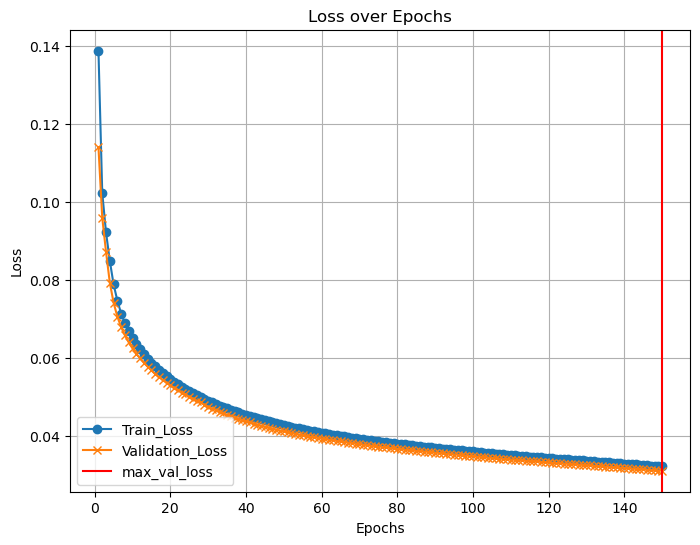

In [16]:
plot_loss(train_loss, val_loss)

### Visual evaluation of training and validation results

In [21]:
batch = next(iter(val_loader))
img_tensor= batch['input']
img= batch['input'][7].squeeze(0).numpy()
gt_img= batch['gt'][7].squeeze(0).numpy()

prediction=model(img_tensor.to("cuda"))
prediction_np=prediction.detach().cpu().numpy()
prediction_np=np.round((prediction_np+1)*255)//2
prediction_np=prediction_np.astype(np.uint8)
prediction_rgb=prediction_np.transpose(0,2,3,1)

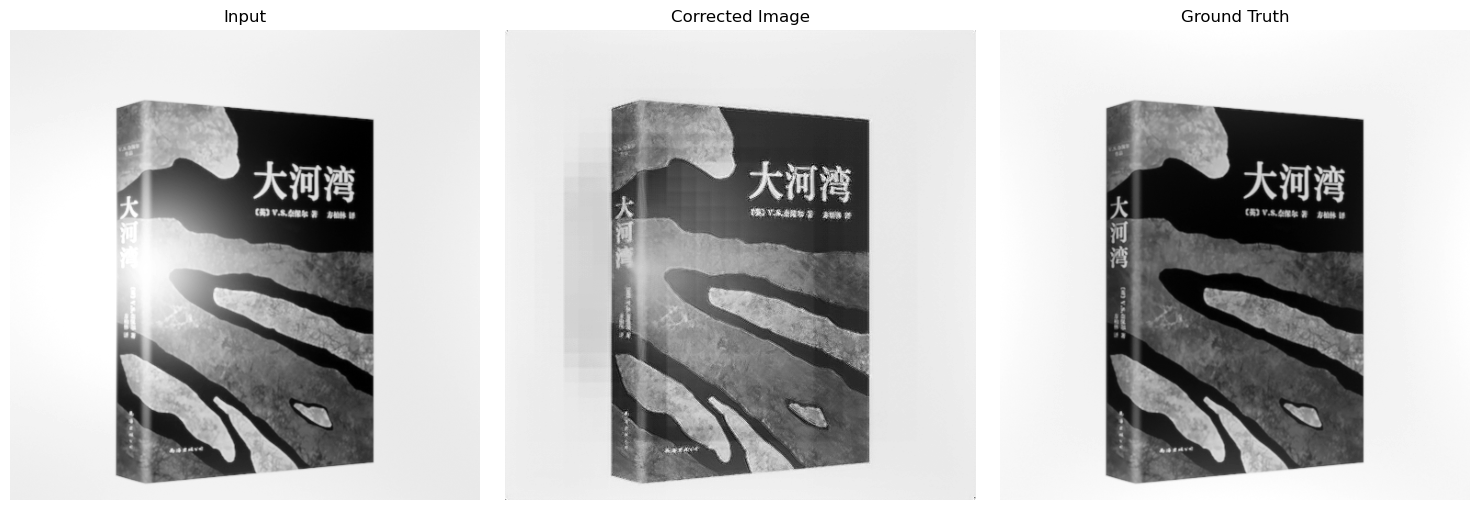

In [22]:
fig = plt.figure(figsize=(15, 5))  

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(np.array(img), cmap='gray')
ax1.set_title("Input")
ax1.axis('off')

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(prediction_rgb[7], cmap='gray')
ax2.set_title("Corrected Image")
ax2.axis('off')

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(gt_img, cmap='gray')
ax3.set_title("Ground Truth")
ax3.axis('off')

plt.tight_layout()
plt.show()

## Inference

### Load pretrained model

In [ ]:
model=UNetAutoencoder().to("cuda")
model.load_state_dict(torch.load("best_model_unet.pth"))

### Inference

In [19]:
transform = transforms.Compose([
            transforms.Resize((512,512)),  
            transforms.ToTensor(),              # Converts to [0, 1] tensor
        ])

image_path="SD1/val/309.png"
img = Image.open(image_path).convert("L")
slice_w, h =512,512
gt_img   = img.crop((0, 0, slice_w, h)) 
input_img = img.crop((slice_w, 0, 2 * slice_w, h))
input_tensor = transform(input_img)
input_tensor = input_tensor.unsqueeze(0)

(1, 512, 512)


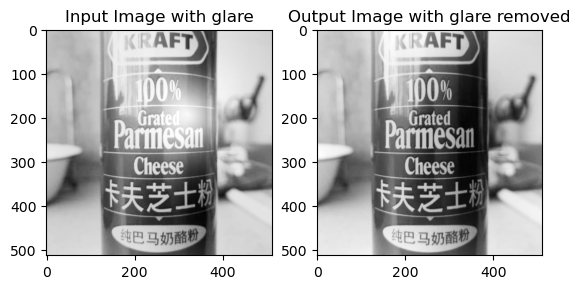

In [20]:
model.eval()
with torch.no_grad():
    input_tensor = input_tensor.to("cuda")

    prediction=model(input_tensor)
    prediction_np=prediction.detach().cpu().squeeze(0).numpy()
    prediction_np=np.round((prediction_np+1)*255)//2
    prediction_np=prediction_np.astype(np.uint8)
    print(prediction_np.shape)
    
    # Visualize
    plt.subplot(1, 2, 1)
    plt.imshow(input_img, cmap='gray')
    plt.title("Input Image with glare")
    
    plt.subplot(1, 2, 2)
    plt.imshow(gt_img, cmap='gray')
    plt.title("Output Image with glare removed")
    
    plt.show()
    